In [1]:
%reset -f

import pandas as pd
import numpy as np
import folium   
import os
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 16})
from matplotlib.transforms import ScaledTranslation
from matplotlib.path import Path
import matplotlib.patches as patches
import seaborn as sns
import nrarfcn as nr
# https://gitlab.com/alexander_marder/earfcn
# https://pypi.org/project/earfcn/0.0.3/
from earfcn.convert import earfcn2freq

/Users/joshuaroypalathinkal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
def plot_binned_map_colormap_contd_step(dataframe, column, step_num = 1e4):

    bounds = [[dataframe['Latitude'].min(), dataframe['Longitude'].min()],
              [dataframe['Latitude'].max(), dataframe['Longitude'].max()]]
    
    step = step_num / 111.32e3
    to_bin = lambda x: np.floor(x / step) * step
    dataframe_focus = dataframe[["Latitude", "Longitude", column]].copy()
    # dataframe_focus[column] = dataframe_focus[column] / 1000 # Mbps
    dataframe_focus.loc[:, "lat_bin"] = to_bin(dataframe_focus["Latitude"])
    dataframe_focus.loc[:, "lon_bin"] = to_bin(dataframe_focus["Longitude"])
    binned = dataframe_focus.groupby(["lat_bin", "lon_bin"]).max().reset_index()
    dataframe_loc = list(binned[["lat_bin", "lon_bin",column]].itertuples(index=False, name=None))
    # print(np.min(binned[column]), np.max(binned[column]))

    fig = folium.Figure(width=600, height=600)
    map = folium.Map(tiles="Cartodb Positron", control_scale=True, zoom_control=False).add_to(fig)
    map.fit_bounds(bounds)

    # legend_bound = (dataframe[column].min(), dataframe[column].max())
    legend_bound = (np.min(binned[column]), np.max(binned[column]))
    # legend_bound = (-120, -40)
    colormap = cm.LinearColormap(['red', 'orange', 'yellow', 'green'], vmin=legend_bound[0], vmax=legend_bound[1]).to_step(index=np.linspace(legend_bound[0], legend_bound[1], 5)).add_to(map)
    colormap.add_to(map)

    for marker in dataframe_loc:
            folium.vector_layers.Rectangle(
                bounds=[[marker[0], marker[1]], [marker[0] + step, marker[1] + step]],
                color=colormap(marker[2]), tooltip=marker[2], fill=True, fill_opacity=.8, opacity=0).add_to(map)
        
    display(map)

In [6]:
df_5g_radio = pd.read_csv('../_data/Spring2025_ArkansasNH/5g_radio.csv', sep=';')
df_5g_pdsch = pd.read_csv('../_data/Spring2025_ArkansasNH/5g_pdsch.csv', sep=';')
df_5g_pusch = pd.read_csv('../_data/Spring2025_ArkansasNH/5g_pusch.csv', sep=';')

df_lte_radio = pd.read_csv('../_data/Spring2025_ArkansasNH/lte_radio.csv', sep=';')
df_lte_pdsch = pd.read_csv('../_data/Spring2025_ArkansasNH/lte_pdsch.csv', sep=';')
df_lte_pusch = pd.read_csv('../_data/Spring2025_ArkansasNH/lte_pusch.csv', sep=';')

In [7]:
df_5g_pdsch = df_5g_pdsch[(df_5g_pdsch['Direction'] == 'Downlink') & (df_5g_pdsch['Test Status'] == 'Completed')].reset_index(drop=True)
df_5g_pusch = df_5g_pusch[(df_5g_pusch['Direction'] == 'Uplink') & (df_5g_pusch['Test Status'] == 'Completed')].reset_index(drop=True)
df_lte_pdsch = df_lte_pdsch[(df_lte_pdsch['Direction'] == 'Downlink') & (df_lte_pdsch['Test Status'] == 'Completed')].reset_index(drop=True)
df_lte_pusch = df_lte_pusch[(df_lte_pusch['Direction'] == 'Uplink') & (df_lte_pusch['Test Status'] == 'Completed')].reset_index(drop=True)

In [8]:
### Renaming LTE & 5G PDSCH Columns
df_lte_pdsch.rename(columns={'RB per Subframe': 'RB per Subframe-Slot'}, inplace=True)
df_5g_pdsch.rename(columns={'Avg Num PDSCH RBs per Slot': 'RB per Subframe-Slot'}, inplace=True)
df_5g_pdsch.rename(columns={'Num PDSCH RBs': 'RBs'}, inplace=True)
df_5g_pdsch.rename(columns={'PDSCH BLER': 'BLER'}, inplace=True)
df_lte_pdsch.rename(columns={'LTE Net PDSCH Throughput': 'Net PDSCH Throughput'}, inplace=True)
df_5g_pdsch.rename(columns={'5G NR Net PDSCH Throughput': 'Net PDSCH Throughput'}, inplace=True)
df_lte_pdsch.rename(columns={'PCI LTE': 'PCI'}, inplace=True)
df_5g_pdsch.rename(columns={'PCI 5G NR': 'PCI'}, inplace=True)

### Norm TP Calculation
df_lte_pdsch['Normalized Throughput'] = (df_lte_pdsch['Net PDSCH Throughput'] * 1e3) / (df_lte_pdsch['RB per Subframe-Slot'] * 15e3 * 12 * df_lte_pdsch['Avg PDSCH Layers'])
df_5g_pdsch['Normalized Throughput'] = (df_5g_pdsch['Net PDSCH Throughput'] * 1e3) / (df_5g_pdsch['RB per Subframe-Slot'] * df_5g_pdsch['PDSCH SCS'] * 1e3 * 12 * df_5g_pdsch['Avg PDSCH Layers'])
df_lte_pdsch.dropna(subset=['Normalized Throughput'], inplace=True)
df_5g_pdsch.dropna(subset=['Normalized Throughput'], inplace=True)

In [9]:
df_lte_radio.replace({'Collection': 'TMO-MNO-IN_1'}, 'TMO-MNO-IN', inplace=True)
df_lte_pdsch.replace({'Collection': 'TMO-MNO-IN_1'}, 'TMO-MNO-IN', inplace=True)
df_lte_pusch.replace({'Collection': 'TMO-MNO-IN_1'}, 'TMO-MNO-IN', inplace=True)
df_5g_radio.replace({'Collection': 'TMO-MNO-IN_1'}, 'TMO-MNO-IN', inplace=True)
df_5g_pdsch.replace({'Collection': 'TMO-MNO-IN_1'}, 'TMO-MNO-IN', inplace=True)
df_5g_pusch.replace({'Collection': 'TMO-MNO-IN_1'}, 'TMO-MNO-IN', inplace=True)

df_lte_radio.replace({'Collection': 'TMO-MNO-IN_2'}, 'TMO-MNO-IN', inplace=True)
df_lte_pdsch.replace({'Collection': 'TMO-MNO-IN_2'}, 'TMO-MNO-IN', inplace=True)
df_lte_pusch.replace({'Collection': 'TMO-MNO-IN_2'}, 'TMO-MNO-IN', inplace=True)
df_5g_radio.replace({'Collection': 'TMO-MNO-IN_2'}, 'TMO-MNO-IN', inplace=True)
df_5g_pdsch.replace({'Collection': 'TMO-MNO-IN_2'}, 'TMO-MNO-IN', inplace=True)
df_5g_pusch.replace({'Collection': 'TMO-MNO-IN_2'}, 'TMO-MNO-IN', inplace=True)

df_lte_radio.replace({'Collection': ['TMO-NH-OUT_1']}, 'TMO-NH-OUT', inplace=True)
df_lte_pdsch.replace({'Collection': ['TMO-NH-OUT_1']}, 'TMO-NH-OUT', inplace=True)
df_lte_pusch.replace({'Collection': ['TMO-NH-OUT_1']}, 'TMO-NH-OUT', inplace=True)
df_5g_radio.replace({'Collection': ['TMO-NH-OUT_1']}, 'TMO-NH-OUT', inplace=True)
df_5g_pdsch.replace({'Collection': ['TMO-NH-OUT_1']}, 'TMO-NH-OUT', inplace=True)
df_5g_pusch.replace({'Collection': ['TMO-NH-OUT_1']}, 'TMO-NH-OUT', inplace=True)

df_lte_radio.replace({'Collection': ['TMO-NH-OUT_2']}, 'TMO-MNO-OUT', inplace=True)
df_lte_pdsch.replace({'Collection': ['TMO-NH-OUT_2']}, 'TMO-MNO-OUT', inplace=True)
df_lte_pusch.replace({'Collection': ['TMO-NH-OUT_2']}, 'TMO-MNO-OUT', inplace=True)
df_5g_radio.replace({'Collection': ['TMO-NH-OUT_2']}, 'TMO-MNO-OUT', inplace=True)
df_5g_pdsch.replace({'Collection': ['TMO-NH-OUT_2']}, 'TMO-MNO-OUT', inplace=True)
df_5g_pusch.replace({'Collection': ['TMO-NH-OUT_2']}, 'TMO-MNO-OUT', inplace=True)

In [11]:
print(df_5g_radio['Collection'].value_counts())
print(df_lte_radio['Collection'].value_counts())

# print(df_5g_pdsch['Collection'].value_counts())
# print(df_lte_pdsch['Collection'].value_counts())

# print(df_5g_pusch['Collection'].value_counts())
# print(df_lte_pusch['Collection'].unique())

Collection
TMO-MNO-IN     36757
TMO-MNO-OUT    20564
Day1_test       4797
Name: count, dtype: int64
Collection
ATT-MNO-OUT    3344
TMO-NH-IN      3015
ATT-MNO-IN     2393
ATT-NH-IN      1714
TMO-MNO-IN     1143
ATT-NH-OUT      524
TMO-NH-OUT      469
Name: count, dtype: int64


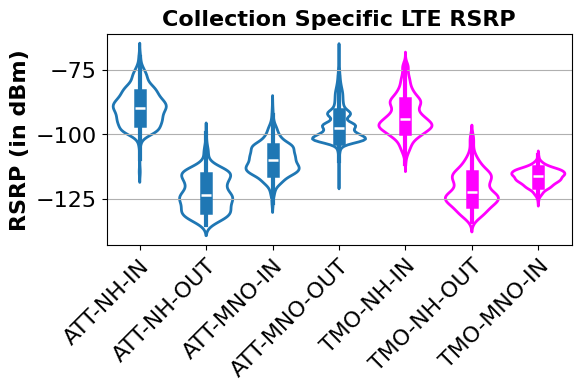

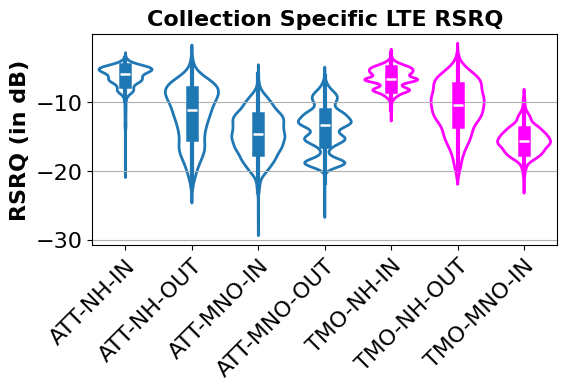

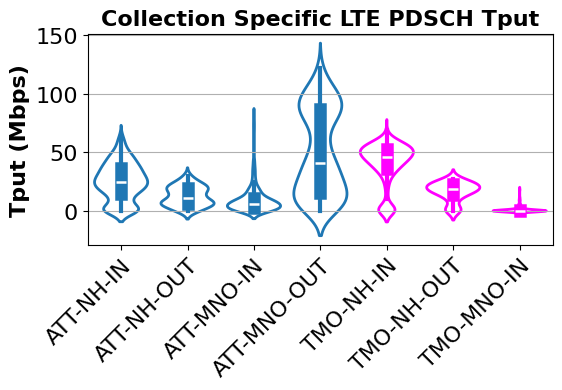

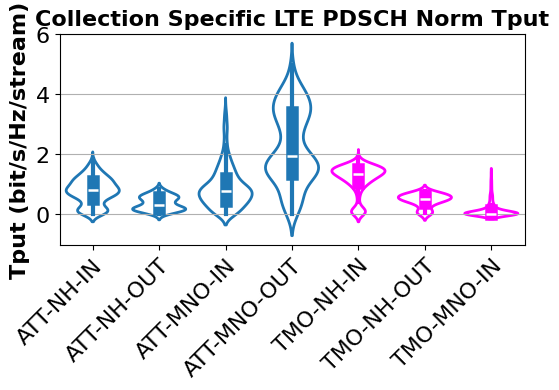

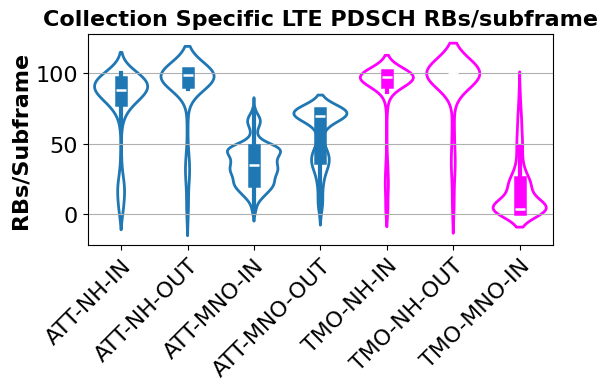

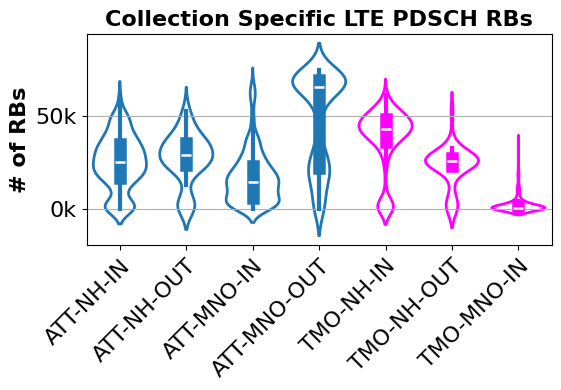

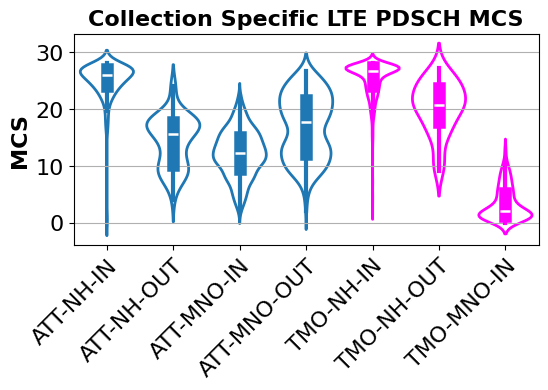

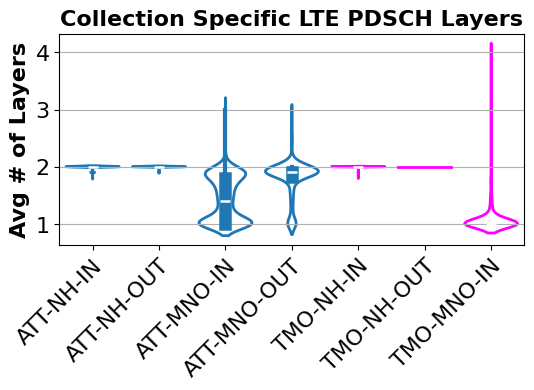

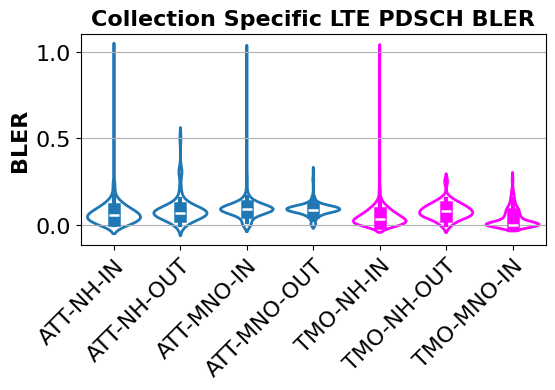

In [13]:
# LTE RSRP
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_radio, x='Collection', y='RSRP', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRP (in dBm)', fontsize=16, fontweight='bold')
plt.title('Collection Specific LTE RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# LTE RSRQ
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_radio, x='Collection', y='RSRQ', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRQ (in dB)', fontsize=16, fontweight='bold')
plt.title('Collection Specific LTE RSRQ', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# LTE PDSCH Total Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_pdsch, x='Collection', y='Net PDSCH Throughput', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('Collection Specific LTE PDSCH Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# LTE PDSCH Norm Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_pdsch, x='Collection', y='Normalized Throughput', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('Collection Specific LTE PDSCH Norm Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# LTE PDSCH RBs/subframe
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_pdsch, x='Collection', y='RB per Subframe-Slot', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RBs/Subframe', fontsize=16, fontweight='bold')
plt.title('Collection Specific LTE PDSCH RBs/subframe', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# LTE PDSCH RBs
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_pdsch, x='Collection', y='RBs', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('# of RBs', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1000)}k'))
plt.title('Collection Specific LTE PDSCH RBs', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# LTE PDSCH MCS
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_pdsch, x='Collection', y='MCS', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('MCS', fontsize=16, fontweight='bold')
plt.title('Collection Specific LTE PDSCH MCS', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# LTE PDSCH Layers
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_pdsch, x='Collection', y='Avg PDSCH Layers', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Avg # of Layers', fontsize=16, fontweight='bold')
plt.title('Collection Specific LTE PDSCH Layers', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# LTE PDSCH BLER
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['ATT-NH-IN', 'ATT-NH-OUT', 'ATT-MNO-IN', 'ATT-MNO-OUT', 'TMO-NH-IN', 'TMO-NH-OUT', 'TMO-MNO-IN']
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta']
sns.violinplot(data=df_lte_pdsch, x='Collection', y='BLER', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('BLER', fontsize=16, fontweight='bold')
plt.title('Collection Specific LTE PDSCH BLER', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

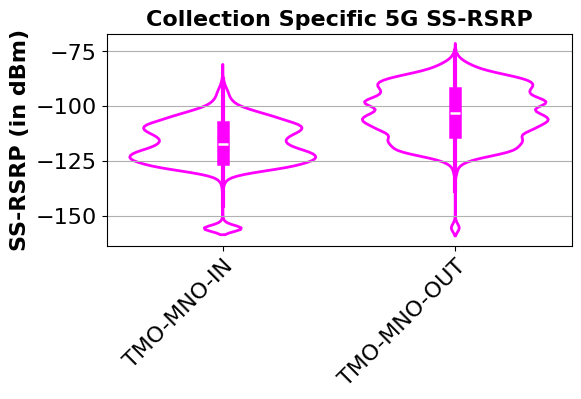

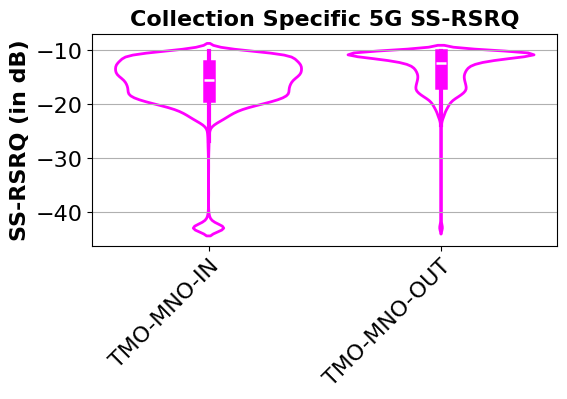

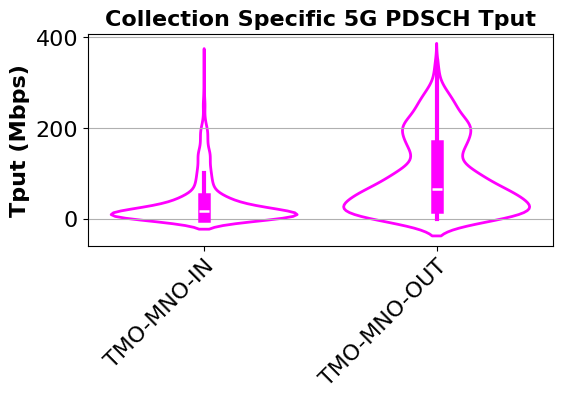

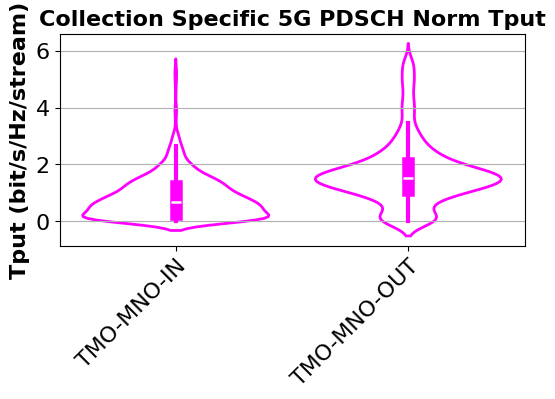

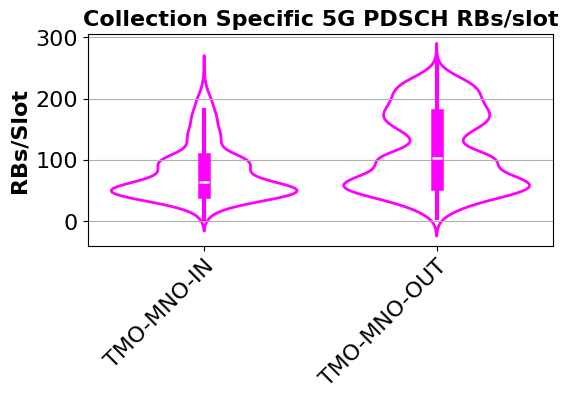

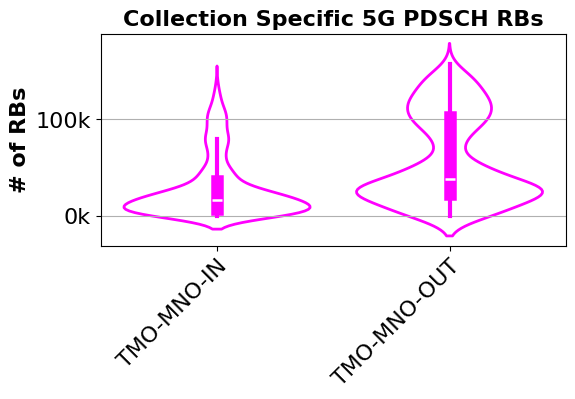

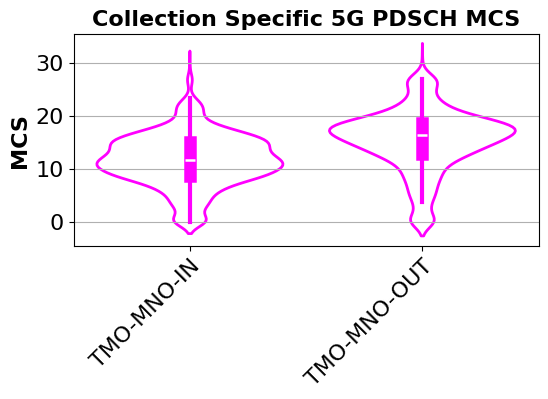

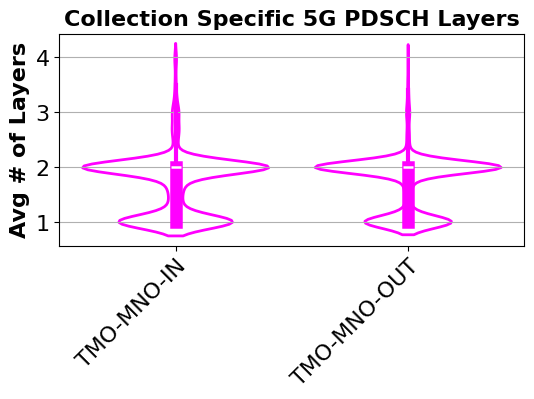

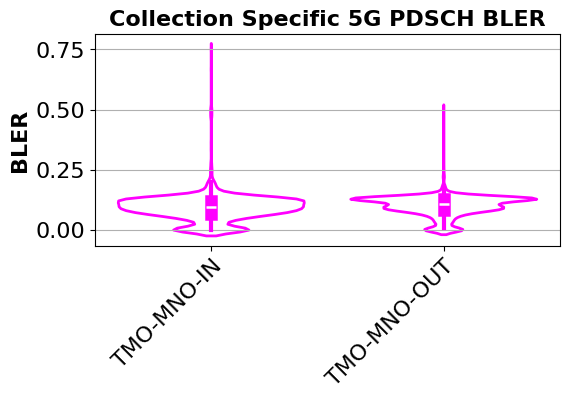

In [14]:
# 5G SS-RSRP
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_radio, x='Collection', y='SS-RSRP', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('SS-RSRP (in dBm)', fontsize=16, fontweight='bold')
plt.title('Collection Specific 5G SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# 5G SS-RSRQ
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_radio, x='Collection', y='SS-RSRQ', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('SS-RSRQ (in dB)', fontsize=16, fontweight='bold')
plt.title('Collection Specific 5G SS-RSRQ', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# 5G PDSCH Total Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_pdsch, x='Collection', y='Net PDSCH Throughput', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('Collection Specific 5G PDSCH Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# 5G PDSCH Norm Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_pdsch, x='Collection', y='Normalized Throughput', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('Collection Specific 5G PDSCH Norm Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# 5G PDSCH RBs/slot
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_pdsch, x='Collection', y='RB per Subframe-Slot', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RBs/Slot', fontsize=16, fontweight='bold')
plt.title('Collection Specific 5G PDSCH RBs/slot', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# 5G PDSCH RBs
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_pdsch, x='Collection', y='RBs', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('# of RBs', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1000)}k'))
plt.title('Collection Specific 5G PDSCH RBs', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# 5G PDSCH MCS
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_pdsch, x='Collection', y='MCS', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('MCS', fontsize=16, fontweight='bold')
plt.title('Collection Specific 5G PDSCH MCS', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# 5G PDSCH Layers
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_pdsch, x='Collection', y='Avg PDSCH Layers', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Avg # of Layers', fontsize=16, fontweight='bold')
plt.title('Collection Specific 5G PDSCH Layers', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

# 5G PDSCH BLER
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['TMO-MNO-IN', 'TMO-MNO-OUT']
palette = ['magenta', 'magenta']
sns.violinplot(data=df_5g_pdsch, x='Collection', y='BLER', hue='Collection', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('BLER', fontsize=16, fontweight='bold')
plt.title('Collection Specific 5G PDSCH BLER', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette